In [1]:
import math
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/test.csv
./data/graph.csv
./data/submission.csv
./data/train.csv


**Change the `data_dir` to the correct data set parent directory**

In [3]:
data_dir = "data"

In [4]:
train_data_path = os.path.join(data_dir, "train.csv")
test_data_path  = os.path.join(data_dir, "test.csv")
graph_data_path = os.path.join(data_dir, "graph.csv")

**Load data sheets to `pandas.DataFrame()`**

In [11]:
train_data = pd.read_csv(train_data_path)
train_data.describe()

,ID,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
count,7100.000000,7100.000000,7100.000000,5771.000000,7100.000000,7100.000000,7.100000e+03,5047.000000,7100.000000,7100.000000,5047.000000
mean,3549.500000,56374.339577,2323.883099,20422.274649,37635.120986,747.273790,6.427069e+05,6250.044185,3.653231,9666.099116,12.197144
std,2049.737788,95058.665054,4742.274729,39262.213465,79067.101832,637.397470,1.127555e+06,13880.694435,2.074042,7779.560336,5.255183
min,0.000000,270.000000,0.000000,0.000000,-989.000000,32.771004,5.459000e+03,10.000000,0.000000,460.300152,2.302896
25%,1774.750000,6097.500000,153.000000,1614.500000,2849.000000,224.815702,1.000775e+05,595.000000,1.928925,3379.288445,8.387037
50%,3549.500000,22892.000000,681.000000,5881.000000,10409.000000,540.836745,2.643235e+05,2068.000000,3.362027,7842.820591,11.351161
75%,5324.250000,62959.250000,2334.000000,26103.000000,32106.500000,1126.282666,7.048395e+05,6134.500000,4.797564,14127.521137,15.396088
max,7099.000000,712475.000000,32957.000000,507499.000000,699453.000000,3187.773001,1.137330e+07,89995.000000,9.741481,49502.860687,38.501190


## Now let's visualize some <br>S.H.I.T. (Scatterplots and Histograms that Interpret the Trend)

In [12]:
# First, we will get the total confirmed/deaths of each state
states = list(np.unique(train_data['Province_State']))
collected = ['Confirmed', 'Deaths', 'People_Tested']
states_data = dict.fromkeys(states, None)

for s in states:
    df_filter = train_data['Province_State'] == s
    state_df = train_data[df_filter]
    states_data[s] = state_df

In [13]:
states_data['California']

,ID,Province_State,Date,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
4,4,California,04-12-2020,22795,640,NaN,22155.0,58.137726,190328.0,5234.0,2.812020,485.423869,22.961176
54,54,California,04-13-2020,23931,714,NaN,23217.0,61.035048,190882.0,3015.0,2.987756,486.836823,12.598721
104,104,California,04-14-2020,25356,767,NaN,24589.0,64.669453,202208.0,5163.0,3.028869,515.723328,20.362044
154,154,California,04-15-2020,26686,860,NaN,25826.0,68.061564,216486.0,5163.0,3.226411,552.138790,19.347223
204,204,California,04-16-2020,27677,956,NaN,26721.0,70.589069,246400.0,5031.0,3.457745,628.433237,18.177548
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6854,6854,California,08-27-2020,691821,12677,NaN,679144.0,1750.903765,10918415.0,NaN,1.832410,27633.006121,NaN
6904,6904,California,08-28-2020,697385,12805,NaN,684580.0,1764.985483,11010637.0,NaN,1.836145,27866.407314,NaN
6954,6954,California,08-29-2020,702038,12894,NaN,689144.0,1776.761586,11109630.0,NaN,1.836653,28116.944977,NaN
7004,7004,California,08-30-2020,705951,12937,NaN,693014.0,1786.664851,11231829.0,NaN,1.832563,28426.213833,NaN


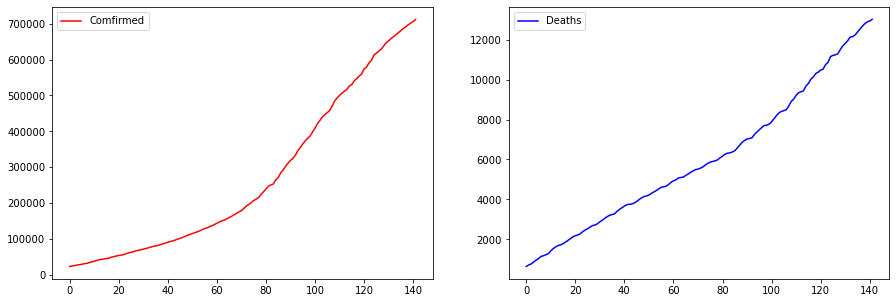

In [86]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.yscale('linear')
plt.plot(states_data['California'].Confirmed.values, color='red', label='Comfirmed')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(states_data['California'].Deaths.values, color='blue', label='Deaths')
plt.legend(loc='best')


## Create Cross-validation Datasets

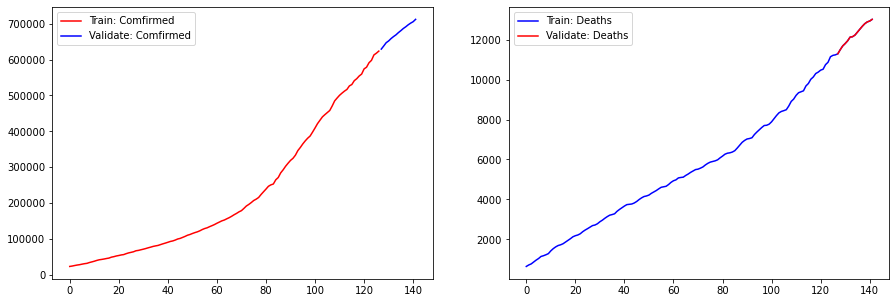

In [112]:
test_percentage = 0.9
validate_percentage = 0.1
state_train_data = {}
state_validate_data = {}

for state in states_data.keys():
    state_data_size = states_data[state].shape
    state_test_size = math.floor(state_data_size[0]*test_percentage)
    state_train_data[state] = states_data[state][:state_test_size]
    state_validate_data[state] = states_data[state][state_test_size:]

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.yscale('linear')
plt.plot(state_train_data['California'].Confirmed.values, color='red', label='Train: Comfirmed')
plt.plot(np.arange(state_train_data['California'].shape[0], state_train_data['California'].shape[0]+state_validate_data['California'].shape[0]), state_validate_data['California'].Confirmed.values, color='blue', label='Validate: Comfirmed')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(states_data['California'].Deaths.values, color='blue', label='Train: Deaths')
plt.plot(np.arange(state_train_data['California'].shape[0], state_train_data['California'].shape[0]+state_validate_data['California'].shape[0]), state_validate_data['California'].Deaths.values, color='red', label='Validate: Deaths')
plt.legend(loc='best')

## Train a RNN model